In [15]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

colors = [(0.0, 0., 1),(1., 0., 0.0)]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained


In [17]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<?, ?it/s]


KeyError: 'Transformer'

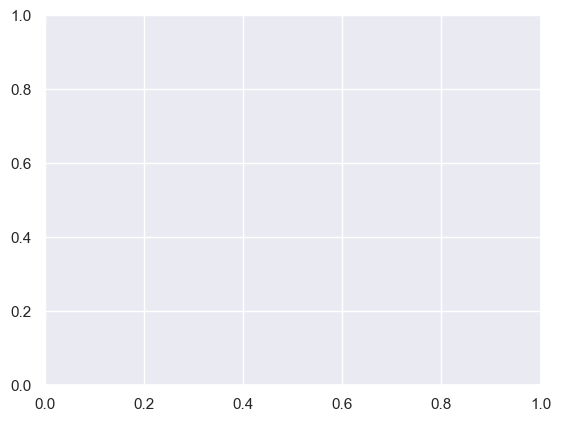

In [18]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

In [27]:
def basic_plot(metrics, models=None, trivial=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.figure

    if models is not None:
        metrics = {k: metrics[k] for k in models}

    color = 1
    ax.axhline(trivial, ls="--", color="gray")
    for name, vs in metrics.items():
        ax.plot(vs["mean"], "-", label=name, color=cmap(color), lw=2)
        low = vs["bootstrap_low"]
        high = vs["bootstrap_high"]
        ax.fill_between(range(len(low)), low, high, alpha=0.3,color=cmap(color))
        color -= 0.25
    ax.set_xlabel("in-context examples",fontsize=16)
    ax.set_ylabel("squared error", fontsize=16)
    ax.set_xlim(-1, len(low) + 0.1)
    ax.set_ylim(-0.1, 1.25)

    # Changed legend position to 'upper right' inside the plot
    legend = ax.legend(loc='upper right', fontsize=16)
    for line in legend.get_lines():
        line.set_linewidth(3)

    ax.tick_params(axis='both', which='major', labelsize=16)
    return fig, ax


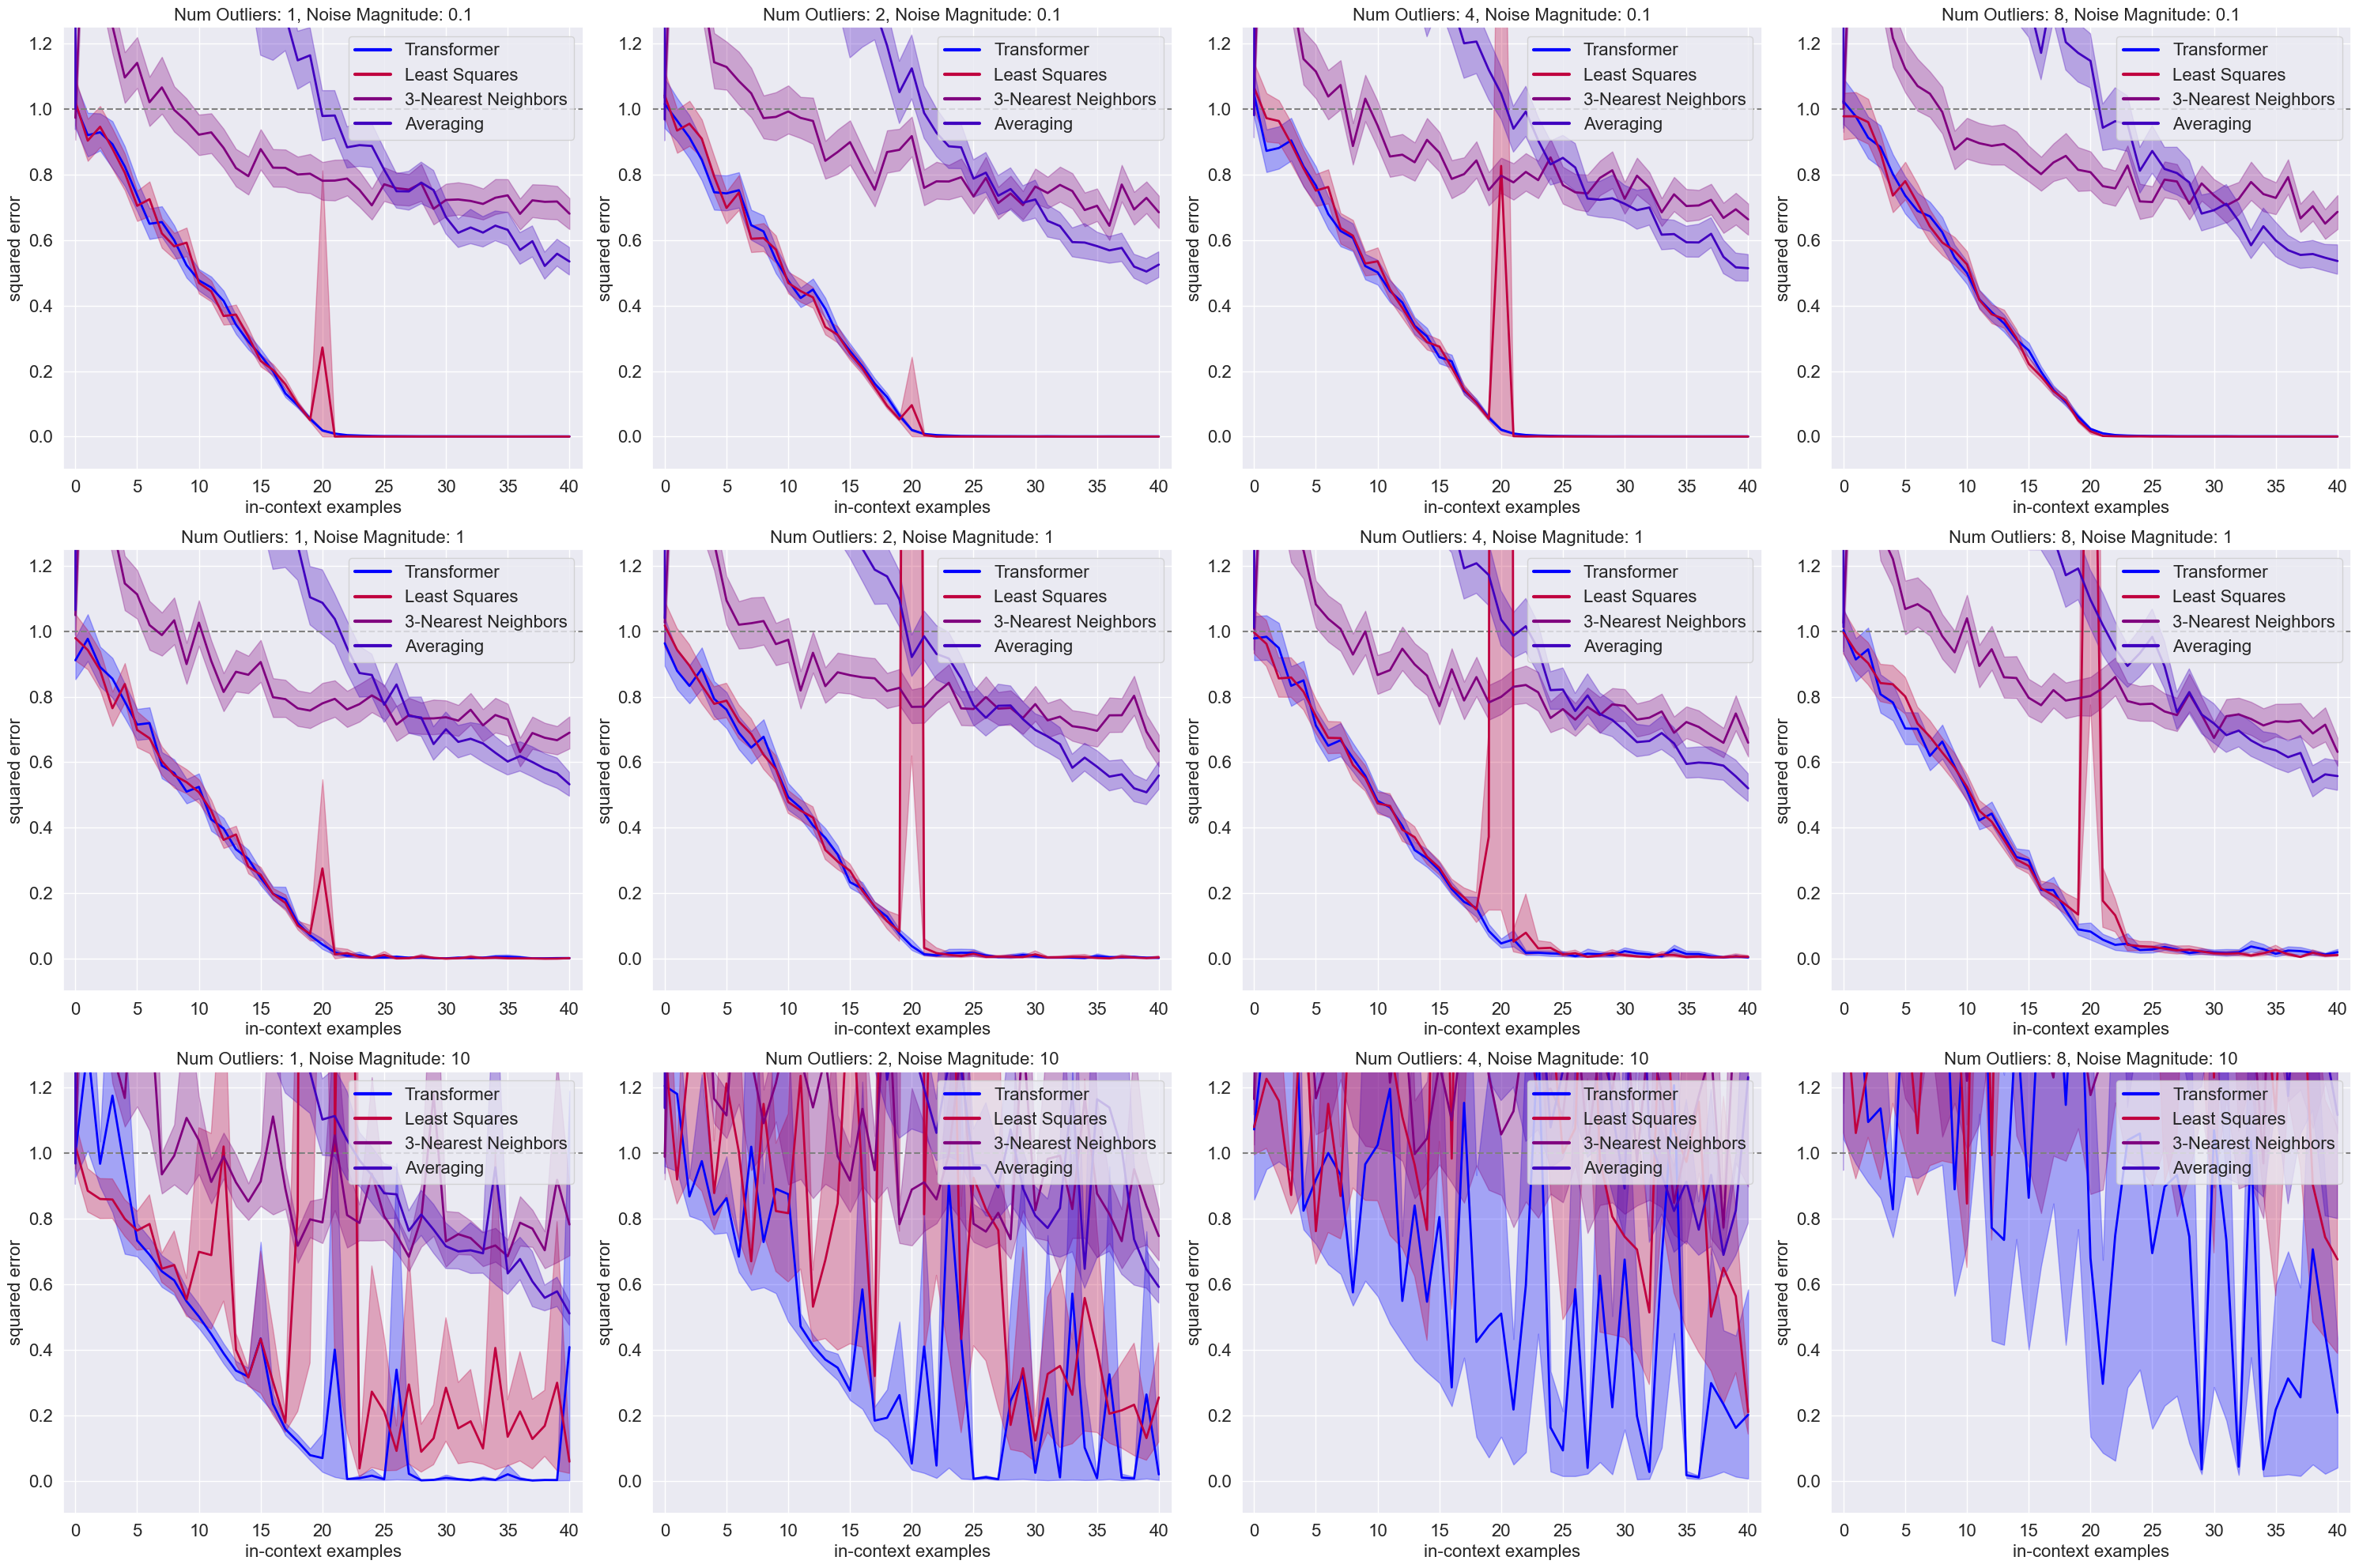

In [28]:
import matplotlib.pyplot as plt

# 设置每个子图的大小
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))  # 4行5列

# 遍历所有的num_outliers和noise_std值
for i, num_outliers in enumerate([1, 2, 4, 8]):
    for j, noise_std in enumerate([0.1, 1, 10]):
        ax = axes[j, i]  # 选择当前的子图位置
        basic_plot(metrics[f"outliers-{num_outliers}-{noise_std}"], models=models, ax=ax)
        ax.set_title(f"Num Outliers: {num_outliers}, Noise Magnitude: {noise_std}",fontsize=16)

# 调整子图之间的间距
plt.tight_layout()
plt.show()
